In [55]:
import pandas as pd
import numpy as np
import random, os, sys 
from groo.groo import get_root
import matplotlib.pyplot as plt
import seaborn as sns

os.path.join(get_root(".tasks_root"))

mdf = pd.read_csv(os.path.join(get_root(".tasks_root"), "contextual-inference", "data", "meta_data.csv"))
mdf = mdf.loc[mdf["StrictInclude"]==1, ]

In [56]:
mdf

,Done,StrictInclude,SubID,main2,schid
3,1,1,aXv2dCm0,2,0
4,1,1,mFs2tQj1,2,1
5,1,1,TXp4tLJ3,4,3
6,1,1,TpL4mXY2,4,2


## Accuracy over time

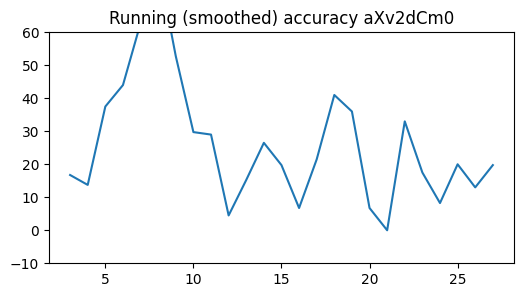

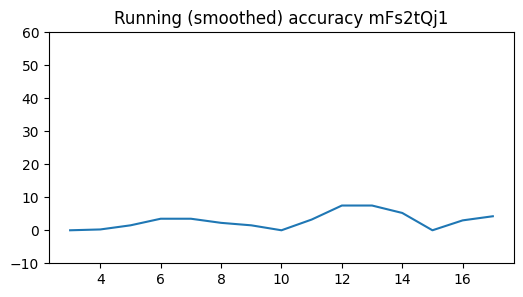

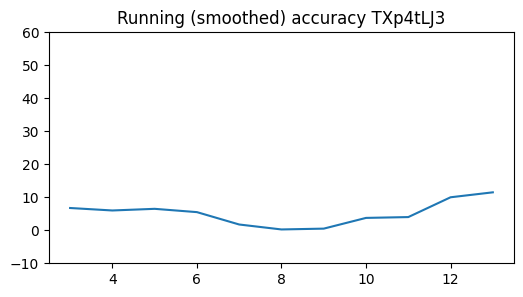

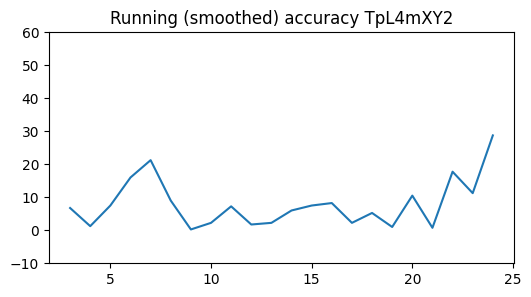

In [57]:
accdf = pd.DataFrame()
for idx, row in mdf.iterrows():
    rdf = pd.DataFrame()
    for cidx, c in enumerate(["r3", "r"+str(row["main2"])]):
        data = pd.read_json(os.path.join(get_root(".tasks_root"), "contextual-inference", "data", row["SubID"]+"_"+c+"_main"+str(cidx+1)+"_"+str(row["schid"])+".json"))
        data["trial"] = data.index
        rat = data.loc[(data["require_rating"]==1) & (data["decision"]==0),["target", "trial", "outcome", "t1_ev", "t2_ev", "rating", "t_slider_shown", "t_response_made"]]
        rat["RT"]  = rat["t_response_made"] - rat["t_slider_shown"]
        rat["err"] = rat["outcome"] - rat["rating"]
    
        rdf = pd.concat([rdf, rat])
    rdf["running_err"] = rdf["err"].rolling(4).mean().abs()
    rdf["SubID"] = row["SubID"]
    rdf= rdf.reset_index()
    #rdf["trial"] = rdf.index
    accdf = pd.concat([accdf, rdf])

    f, ax = plt.subplots(1,1,figsize=(6,3))
    ax.plot(rdf.index, rdf["running_err"])
    ax.set_title("Running (smoothed) accuracy "+ row["SubID"])
    ax.set_ylim(-10, 60)
accdf = accdf.reset_index()

In [58]:
accdf

,level_0,index,target,trial,outcome,t1_ev,t2_ev,rating,t_slider_shown,t_response_made,RT,err,running_err,SubID
0,0,20,1.0,20,3.0,5.0,-15.0,28.0,1222170.2,1227377.2,5207.0,-25.0,NaN,aXv2dCm0
1,1,28,2.0,28,0.0,0.0,0.0,11.0,1319719.4,1342944.9,23225.5,-11.0,NaN,aXv2dCm0
2,2,32,2.0,32,-22.0,-20.0,-20.0,8.0,1378736.4,1387077.1,8340.7,-30.0,NaN,aXv2dCm0
3,3,39,2.0,39,-1.0,0.0,0.0,0.0,1450634.8,1453410.9,2776.1,-1.0,16.75,aXv2dCm0
4,4,40,2.0,40,-3.0,0.0,0.0,10.0,1462183.6,1466410.7,4227.1,-13.0,13.75,aXv2dCm0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,20,47,1.0,47,39.0,40.0,-20.0,5.0,1890500.9,1894710.7,4209.8,34.0,10.50,TpL4mXY2
81,21,49,1.0,49,24.0,25.0,5.0,34.0,1912186.0,1915160.9,2974.9,-10.0,0.75,TpL4mXY2
82,22,50,1.0,50,-34.0,-35.0,45.0,30.0,1923953.9,1927995.2,4041.3,-64.0,17.75,TpL4mXY2
83,23,51,2.0,51,-3.0,0.0,0.0,2.0,1936733.7,1938911.5,2177.8,-5.0,11.25,TpL4mXY2


<Axes: xlabel='trial', ylabel='running_err'>

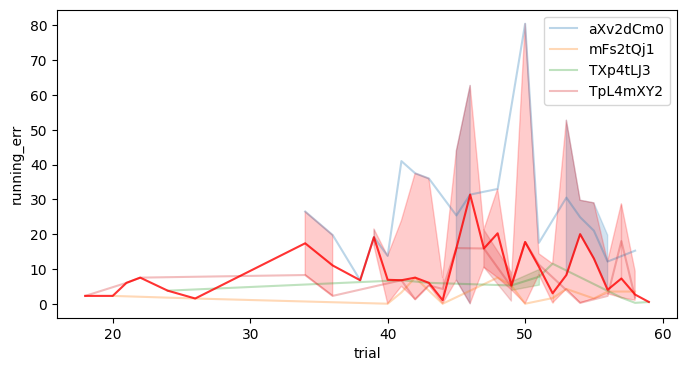

In [59]:
f, ax = plt.subplots(1,1,figsize=(8,4))
sns.lineplot(data = accdf, x="trial", y="running_err",hue="SubID", alpha=0.3, color="gray", estimator="median", errorbar=('ci', 68), ax=ax)
sns.lineplot(data = accdf, x="trial", y="running_err",alpha=0.8, color="red", estimator="median", errorbar=('ci', 68), ax=ax)

<Axes: xlabel='trial_bin', ylabel='running_err'>

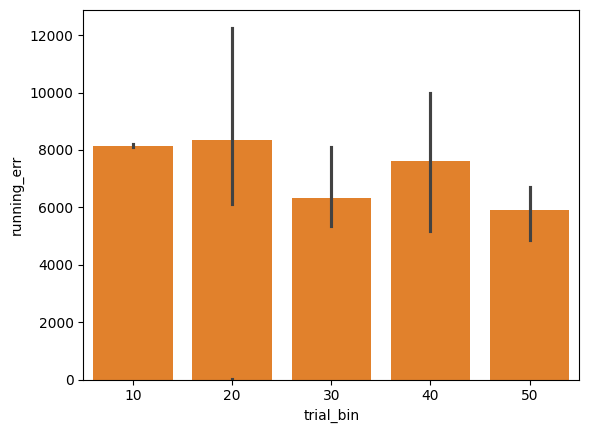

In [63]:
accdf["trial_bin"] = (accdf["trial"] // 10) * 10

# Aggregate RT and running_err by SubID and trial_bin
agg_df = accdf.groupby(["SubID", "trial_bin"]).agg(
    {"RT": "mean", "running_err": "mean"}
).reset_index()

sns.barplot(agg_df, x="trial_bin", y="running_err")

sns.barplot(agg_df, x="trial_bin", y="RT")

## Choices 

In [ ]:
data = pd.read_json(os.path.join(get_root(".tasks_root"), "contextual-inference", "data", ids[ii]+"_"+c+"_main"+str(cidx+1)+"_"+str(schid)+".json"))
chdata = data.loc[(data["decision"]==1),["target", "outcome", "t1_ev", "t2_ev", "choice", "t_ch_targets_shown", "t_ch_choice_made"]]
chdata["rt"] = chdata["t_ch_choice_made"] - chdata["t_ch_targets_shown"]